# Import Functions

In [1]:
!pip install pandas numpy matplotlib nltk scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/akaagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/akaagi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Preprocess

In [4]:
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates().reset_index(drop=True)
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("All column names have been striped, lowered case, replaced space with underscore if any")
    print("Dropped duplicated instances if any")
    print("Categorical instances have been striped")
    return df

pd.set_option('display.max_colwidth', 255)

df1 =pd.read_csv('../data_raw/Poem_classification - train_data.csv')
df1 = df1.dropna()
df1 = trim(df1)

df2 =pd.read_csv('../data_raw/Poem_classification - test_data.csv')
df2 = df2.dropna()
df2 = trim(df2)

df = pd.concat([df1, df2], ignore_index=True)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)
        
def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')
        
df.head(3)

All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped
All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped


,genre,poem
0,Music,"In the thick brushthey spend the hottest part of the day, soaking their hoovesin the trickle of mountain water the ravine hoardson behalf of the oleander."
1,Music,"Storms are generous. Something so easy to surrender to, sitting by the window, and then you step out into the garden you were so bored of,"
2,Music,"—After Ana Mendieta Did you carry around the matin star? Did you hold forest-fire in one hand? Would you wake to radiate, shimmer, gleam lucero-light? Through the morning would you measure the wingspan of an idea taking off— & by night would"


In [5]:
shape(df,'df')


STATUS: Dimension of "df" = (985, 2)


## Word Counts of poem's genre

In [6]:
genre_poem_list = [] ; word_count_list =[]
for genre in df['genre'].unique():
    df_filter = df.loc[(df['genre'] == genre)]
    word_count_temp = df_filter['poem'].str.split().str.len().sum()
    genre_poem_list.append(genre)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Genre':genre_poem_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)



,Genre,Word Count
0,Death,11734
1,Affection,11622
2,Music,11560
3,Environment,11173


In [7]:
total_word_count = df['poem'].str.split().str.len().sum()
print(f'The word count of all transcription is: {int(total_word_count)}')

The word count of all transcription is: 46089


## Sample Size of Each Genre

In [8]:
vc(df, 'genre')

STATUS: Value counts of "genre"...


,count,percentage (%)
genre,,
Environment,252,25.583756
Music,250,25.380711
Death,242,24.568528
Affection,241,24.467005


# Text Normalisation

1.Lowe Case\
2.Removing punctuation and numbers\
3.Tokenisation of the transcription\
4.Lemmatisation\
5.Remove Stop Words


## Lower Case 

In [9]:
# To convert transcription into lowercase
def lower(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : str.lower(x))
    return df
df = lower(df,'poem')
df.head(3)

,genre,poem
0,Music,"in the thick brushthey spend the hottest part of the day, soaking their hoovesin the trickle of mountain water the ravine hoardson behalf of the oleander."
1,Music,"storms are generous. something so easy to surrender to, sitting by the window, and then you step out into the garden you were so bored of,"
2,Music,"—after ana mendieta did you carry around the matin star? did you hold forest-fire in one hand? would you wake to radiate, shimmer, gleam lucero-light? through the morning would you measure the wingspan of an idea taking off— & by night would"


## Remove Punctuation and Numbers

In [10]:
# To remove transcription punctuation and numbers

def remove_punc_num(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : " ".join(re.findall('[\w]+',x)))
    df[attribute] = df[attribute].str.replace('\d+', '')
    return df
df =remove_punc_num(df, 'poem')
df_no_punc =df.copy()
df.head(3)

,genre,poem
0,Music,in the thick brushthey spend the hottest part of the day soaking their hoovesin the trickle of mountain water the ravine hoardson behalf of the oleander
1,Music,storms are generous something so easy to surrender to sitting by the window and then you step out into the garden you were so bored of
2,Music,after ana mendieta did you carry around the matin star did you hold forest fire in one hand would you wake to radiate shimmer gleam lucero light through the morning would you measure the wingspan of an idea taking off by night would


## Tokenisation

In [11]:
# to tokenise transcription

# import nltk
tk =WhitespaceTokenizer()
def tokenise(df, attribute):
    df['tokenised'] = df.apply(lambda row: tk.tokenize(str(row[attribute])), axis=1)
    return df
df =tokenise(df, 'poem')
df_experiment =df.copy()
df.head(3)

,genre,poem,tokenised
0,Music,in the thick brushthey spend the hottest part of the day soaking their hoovesin the trickle of mountain water the ravine hoardson behalf of the oleander,"[in, the, thick, brushthey, spend, the, hottest, part, of, the, day, soaking, their, hoovesin, the, trickle, of, mountain, water, the, ravine, hoardson, behalf, of, the, oleander]"
1,Music,storms are generous something so easy to surrender to sitting by the window and then you step out into the garden you were so bored of,"[storms, are, generous, something, so, easy, to, surrender, to, sitting, by, the, window, and, then, you, step, out, into, the, garden, you, were, so, bored, of]"
2,Music,after ana mendieta did you carry around the matin star did you hold forest fire in one hand would you wake to radiate shimmer gleam lucero light through the morning would you measure the wingspan of an idea taking off by night would,"[after, ana, mendieta, did, you, carry, around, the, matin, star, did, you, hold, forest, fire, in, one, hand, would, you, wake, to, radiate, shimmer, gleam, lucero, light, through, the, morning, would, you, measure, the, wingspan, of, an, idea, takin..."


## Stemming

In [12]:
from nltk.stem.snowball import SnowballStemmer
def stemming(df, attribute):
    # Use English stemmer.
    stemmer = SnowballStemmer("english")
    df['stemmed'] = df[attribute].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
    return df
df =stemming(df_experiment, 'tokenised')
df.head(2)

,genre,poem,tokenised,stemmed
0,Music,in the thick brushthey spend the hottest part of the day soaking their hoovesin the trickle of mountain water the ravine hoardson behalf of the oleander,"[in, the, thick, brushthey, spend, the, hottest, part, of, the, day, soaking, their, hoovesin, the, trickle, of, mountain, water, the, ravine, hoardson, behalf, of, the, oleander]","[in, the, thick, brushthey, spend, the, hottest, part, of, the, day, soak, their, hoovesin, the, trickl, of, mountain, water, the, ravin, hoardson, behalf, of, the, oleand]"
1,Music,storms are generous something so easy to surrender to sitting by the window and then you step out into the garden you were so bored of,"[storms, are, generous, something, so, easy, to, surrender, to, sitting, by, the, window, and, then, you, step, out, into, the, garden, you, were, so, bored, of]","[storm, are, generous, someth, so, easi, to, surrend, to, sit, by, the, window, and, then, you, step, out, into, the, garden, you, were, so, bore, of]"


## Stop Words Removal

In [13]:
# Showing the list of the English stop words, it has a number of 179 stop words in this list

stop = stopwords.words('english')
print(f"There are {len(stop)} stop words \n")
print(stop)

There are 179 stop words 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'ow

In [14]:
# Removing stop words
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['stemmed_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df
df = remove_stop_words(df, 'stemmed')
df.head(2)

,genre,poem,tokenised,stemmed,stemmed_without_stop
0,Music,in the thick brushthey spend the hottest part of the day soaking their hoovesin the trickle of mountain water the ravine hoardson behalf of the oleander,"[in, the, thick, brushthey, spend, the, hottest, part, of, the, day, soaking, their, hoovesin, the, trickle, of, mountain, water, the, ravine, hoardson, behalf, of, the, oleander]","[in, the, thick, brushthey, spend, the, hottest, part, of, the, day, soak, their, hoovesin, the, trickl, of, mountain, water, the, ravin, hoardson, behalf, of, the, oleand]",thick brushthey spend hottest part day soak hoovesin trickl mountain water ravin hoardson behalf oleand
1,Music,storms are generous something so easy to surrender to sitting by the window and then you step out into the garden you were so bored of,"[storms, are, generous, something, so, easy, to, surrender, to, sitting, by, the, window, and, then, you, step, out, into, the, garden, you, were, so, bored, of]","[storm, are, generous, someth, so, easi, to, surrend, to, sit, by, the, window, and, then, you, step, out, into, the, garden, you, were, so, bore, of]",storm generous someth easi surrend sit window step garden bore


In [15]:
df =df.drop(['poem','stemmed', 'tokenised'], axis=1)
df.head()

,genre,stemmed_without_stop
0,Music,thick brushthey spend hottest part day soak hoovesin trickl mountain water ravin hoardson behalf oleand
1,Music,storm generous someth easi surrend sit window step garden bore
2,Music,ana mendieta carri around matin star hold forest fire one hand would wake radiat shimmer gleam lucero light morn would measur wingspan idea take night would
3,Music,aja sherrard 20the portent may memori wallac stevenshow hard carri score adult back look carrion need distressof loyalti requir pain
4,Music,bob marley bavaria novemb 1980 brilliant morn fish boat dream die man midwint world cover light shadow dream st ann


In [16]:
total_word_count_normalised = df['stemmed_without_stop'].str.split().str.len().sum()
print(f'The word count of transcription after normalised is: {int(total_word_count_normalised)}')
print(f'{round((total_word_count - total_word_count_normalised)/total_word_count*100, 2)}% less word')

The word count of transcription after normalised is: 26153
43.26% less word


In [17]:
le = preprocessing.LabelEncoder()
le.fit(df['genre'])
df['encoded_target'] = le.transform(df['genre'])
df.head()

,genre,stemmed_without_stop,encoded_target
0,Music,thick brushthey spend hottest part day soak hoovesin trickl mountain water ravin hoardson behalf oleand,3
1,Music,storm generous someth easi surrend sit window step garden bore,3
2,Music,ana mendieta carri around matin star hold forest fire one hand would wake radiat shimmer gleam lucero light morn would measur wingspan idea take night would,3
3,Music,aja sherrard 20the portent may memori wallac stevenshow hard carri score adult back look carrion need distressof loyalti requir pain,3
4,Music,bob marley bavaria novemb 1980 brilliant morn fish boat dream die man midwint world cover light shadow dream st ann,3


# Text N-Gram Feature Extraction

In [18]:
# function to flatten one list
def flat_list(unflat_list):
    flatted = [item for sublist in unflat_list for item in sublist]
    return flatted

def to_list(df, attribute):
    # Select the normalised transcript column 
    df_transcription = df[[attribute]]
    # To convert the attribute into list format, but it has inner list. So it cannot put into the CountVectoriser
    unflat_list_transcription = df_transcription.values.tolist()
    # Let's use back the function defined above, "flat_list", to flatten the list
    flat_list_transcription = flat_list(unflat_list_transcription)
    return flat_list_transcription
flat_list_transcription = to_list(df, 'stemmed_without_stop')

## Extract 5 Types of N-Gram 

In [19]:
n_gram_features ={'unigram':(1,1),'unigram_bigram':(1,2),'bigram':(2,2),\
       'bigram_trigram':(2,3),'trigram':(3,3)}
feature_name=[]
temp=[]
for key, values in n_gram_features.items():
    temp.append(key)
    feature_name.append(key)
temp

['unigram', 'unigram_bigram', 'bigram', 'bigram_trigram', 'trigram']

In [20]:
def generate_n_gram_features(flat_list_transcription):
    temp=[]
    for key, values in n_gram_features.items(): 
        vectorizer = CountVectorizer(ngram_range=values)
        vectorizer.fit(flat_list_transcription)
        temp.append(vectorizer.transform(flat_list_transcription))
    return temp
temp = generate_n_gram_features(flat_list_transcription)

## Dimension of Each Feature Vector ¶

In [21]:
dataframes = {'unigram':temp[0], 
              'unigram_bigram':temp[1], 
              'bigram':temp[2], 
              'bigram_trigram':temp[3], 
              'trigram':temp[4]}
feature_vector = [] ; feature_vector_shape = []
for key in dataframes:
    feature_vector.append(key)
    feature_vector_shape.append(dataframes[key].shape)

n_gram_df = pd.DataFrame({'N-Gram Feature Vector':feature_vector, 'Data Dimension':feature_vector_shape})
n_gram_df

,N-Gram Feature Vector,Data Dimension
0,unigram,"(985, 7180)"
1,unigram_bigram,"(985, 29557)"
2,bigram,"(985, 22377)"
3,bigram_trigram,"(985, 44480)"
4,trigram,"(985, 22103)"


# Text Classification Modelling 

In [22]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
random_state_number =1234
df_target =df[['encoded_target']].values.ravel()

In [23]:
metrics = {
    'f1':[f1_score, 'f1_macro'], 
    'precision': [precision_score, 'precision_macro'], 
    'recall': [recall_score, 'recall_macro']
}

# get evaluation result

def get_performance(param_grid, base_estimator, dataframes):
    df_name_list =[]; best_estimator_list=[]; best_score_list=[]; test_predict_result_list=[];
    metric_list = [];
    
    for df_name, df in dataframes.items():
        
        X_train, X_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2, random_state=random_state_number)
        for _, metric_dict in metrics.items():
            sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, scoring=metric_dict[1],random_state=random_state_number,
                                      factor=2).fit(X_train, y_train)

            best_estimator = sh.best_estimator_
            clf = best_estimator.fit(X_train, y_train)
            prediction = clf.predict(X_test)
            test_predict_result = metric_dict[0](y_test, prediction, average='macro')

            df_name_list.append(df_name) ; best_estimator_list.append(best_estimator) ; 
            best_score_list.append(sh.best_score_) ; 
            test_predict_result_list.append(test_predict_result) ;metric_list.append(metric_dict[1])
            
            
    model_result = pd.DataFrame({'Vector':df_name_list,'Metric':metric_list,
                               'Calibrated Estimator':best_estimator_list,
                               'Best CV Metric Score':best_score_list, 'Test Predict Metric Score': test_predict_result_list})
    return model_result

## Visualising Classification Prediction 

In [24]:
def vis_classification(vector_type = 'unigram', estimator = KNeighborsClassifier(n_neighbors=9)):
    pca = PCA(n_components=2)
    df1 = pca.fit_transform(np.asarray(dataframes[vector_type].todense()))
    X_train, X_test, y_train, y_test = train_test_split(df1, df_target, test_size=0.2, random_state=random_state_number)
    
    # get training set
    df2 = pd.DataFrame({'pca1':X_train[:,1], 'pca2': X_train[:,0], 'y':le.inverse_transform(y_train)})
    min_1, max_1 = df2['pca1'].min(), df2['pca1'].max()
    min_2, max_2 = df2['pca2'].min(), df2['pca2'].max()
    
    # generate dimension reduced, but extended data
    pca1_range = np.linspace(min_1,max_1,30)
    pca2_range = np.linspace(min_2,max_2,30)
    
    # shuffle
    np.random.shuffle(pca1_range) ; np.random.shuffle(pca2_range)
    
    # to dataframe
    prediction_test = pd.DataFrame({'pca1':pca1_range, 'pca2':pca2_range})

    best_estimator = estimator
    
    # fit training set and predict extended data
    clf = best_estimator.fit(X_train, y_train)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6))
    cmap = plt.cm.get_cmap('tab10', 4)
    fig.suptitle(f"Visualising {type(estimator).__name__} on {vector_type.capitalize()} Vector", fontsize=14,fontweight='bold')


    def plot_scatter(ax, predictor_set, target, title):
        
        # plot area classifier
        clf = best_estimator.fit(X_train, y_train)
        axs[0].tricontourf(X_train[:,0], X_train[:,1], clf.predict(X_train), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")
        
        axs[1].tricontourf(X_test[:,0], X_test[:,1], clf.predict(X_test), levels=np.arange(-0.5, 4), zorder=10, alpha=0.3, cmap=cmap, edgecolors="k")
        
        # plot scatter
        df3 = pd.DataFrame({'pca1':predictor_set[:,1], 'pca2': predictor_set[:,0], 'y':le.inverse_transform(target)})
        for y_label in df3['y'].unique():
            df_filter = df3[df3['y']==y_label]
            ax.scatter(df_filter['pca1'], df_filter['pca2'], alpha=1,label=f"{y_label}")
        ax.legend()
        ax.set_title(f'{title} ({predictor_set.shape[0]} Samples)',fontweight='bold')
    plot_scatter(axs[0], X_train, y_train, 'Training Set')
    plot_scatter(axs[1], X_test, y_test, 'Testing Set')
    axs[0].sharey(axs[1])
    return plt.show()

In [25]:
param_grid = {'max_depth': [None,30,32,35,37,38,39,40],'min_samples_split': [2,150,170,180,190,200]}
base_estimator = RandomForestClassifier(random_state=random_state_number)
rfc_result = get_performance(param_grid, base_estimator, dataframes)
rfc_result

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=40, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=40, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=40...",0.440763,0.463258
1,unigram,precision_macro,"(DecisionTreeClassifier(max_features='sqrt', random_state=822569775), DecisionTreeClassifier(max_features='sqrt', random_state=2137449171), DecisionTreeClassifier(max_features='sqrt', random_state=524453158), DecisionTreeClassifier(max_features='sqrt'...",0.459416,0.445446
2,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=30, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=30...",0.453674,0.465550
3,unigram_bigram,f1_macro,"(DecisionTreeClassifier(max_depth=35, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=35, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=35...",0.428977,0.441152
4,unigram_bigram,precision_macro,"(DecisionTreeClassifier(max_depth=35, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=35, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=35...",0.440094,0.457169
5,unigram_bigram,recall_macro,"(DecisionTreeClassifier(max_depth=35, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=35, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=35...",0.433338,0.450469
6,bigram,f1_macro,"(DecisionTreeClassifier(max_depth=40, max_features='sqrt', min_samples_split=190,\n random_state=822569775), DecisionTreeClassifier(max_depth=40, max_features='sqrt', min_samples_split=190,\n random_state=21...",0.134897,0.155541
7,bigram,precision_macro,"(DecisionTreeClassifier(max_depth=35, max_features='sqrt', min_samples_split=200,\n random_state=822569775), DecisionTreeClassifier(max_depth=35, max_features='sqrt', min_samples_split=200,\n random_state=21...",0.176048,0.172390
8,bigram,recall_macro,"(DecisionTreeClassifier(max_depth=35, max_features='sqrt', min_samples_split=200,\n random_state=822569775), DecisionTreeClassifier(max_depth=35, max_features='sqrt', min_samples_split=200,\n random_state=21...",0.242187,0.228750
9,bigram_trigram,f1_macro,"(DecisionTreeClassifier(max_features='sqrt', min_samples_split=180,\n random_state=822569775), DecisionTreeClassifier(max_features='sqrt', min_samples_split=180,\n random_state=2137449171), DecisionTreeClass...",0.152072,0.132900


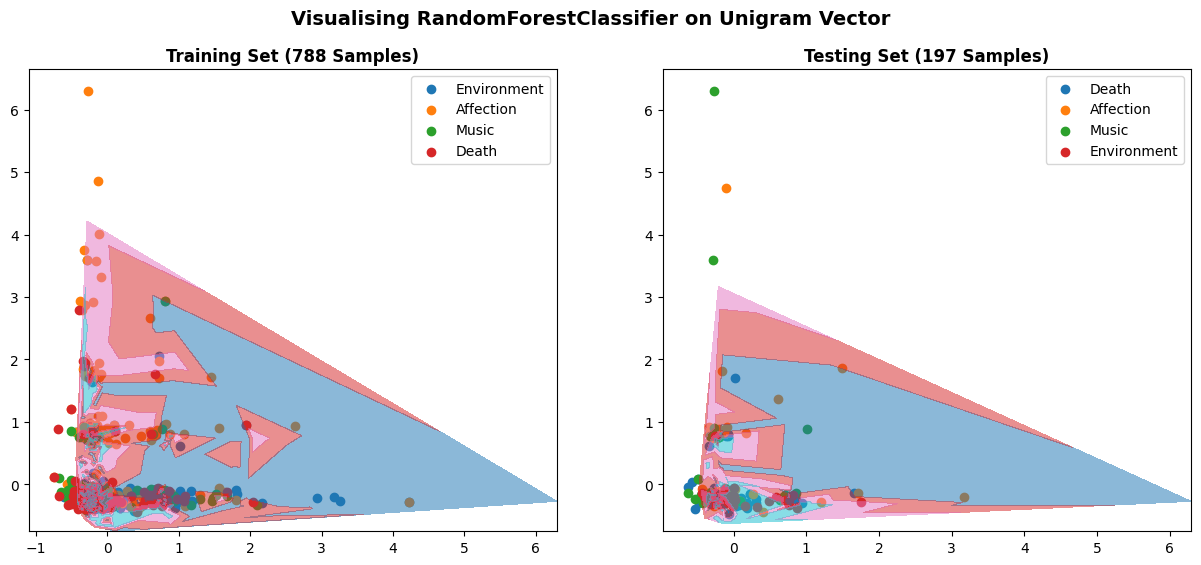

In [26]:
def get_best_vector_clf(knn_result):

    temp = knn_result[knn_result['Metric'] =='f1_macro']
    temp2 = temp.iloc[temp['Best CV Metric Score'].idxmax()].to_frame().T
    best_vector = temp2['Vector'].values[0]
    best_clf = temp2['Calibrated Estimator'].values[0]
    
    return best_vector, best_clf

best_vector, best_clf =  get_best_vector_clf(rfc_result)
vis_classification(vector_type = best_vector, estimator = best_clf)

## Dimensionality Reduction 

In [27]:

df_temp = rfc_result[rfc_result['Metric'] =='f1_macro']
vector_rfc = df_temp[['Vector','Calibrated Estimator']].set_index('Vector').to_dict()['Calibrated Estimator']
vector_rfc

{'unigram': RandomForestClassifier(max_depth=40, random_state=1234),
 'unigram_bigram': RandomForestClassifier(max_depth=35, random_state=1234),
 'bigram': RandomForestClassifier(max_depth=40, min_samples_split=190, random_state=1234),
 'bigram_trigram': RandomForestClassifier(min_samples_split=180, random_state=1234),
 'trigram': RandomForestClassifier(min_samples_split=170, random_state=1234)}

In [28]:
supported_columns_dict = {}
for df_name, df in dataframes.items():
    X_train, X_test, y_train, y_test = train_test_split(dataframes[df_name], df_target, test_size=0.2, random_state=random_state_number)

    selector = SelectFromModel(estimator=vector_rfc[df_name]).fit(X_train, y_train)
    
    filter_columns = selector.get_support()
    dataframes[df_name] = dataframes[df_name][:, filter_columns]
    
shape_dim = [] ; df_names = []
for df_name, df in dataframes.items():
    shape_dim.append(df.shape)
    df_names.append(df_name)
n_gram_df_dim = pd.DataFrame({'N-Gram Feature Vector':df_names, 'Data Dimension':shape_dim}) 
n_gram_df_dim

,N-Gram Feature Vector,Data Dimension
0,unigram,"(985, 1617)"
1,unigram_bigram,"(985, 5601)"
2,bigram,"(985, 3415)"
3,bigram_trigram,"(985, 16344)"
4,trigram,"(985, 8911)"


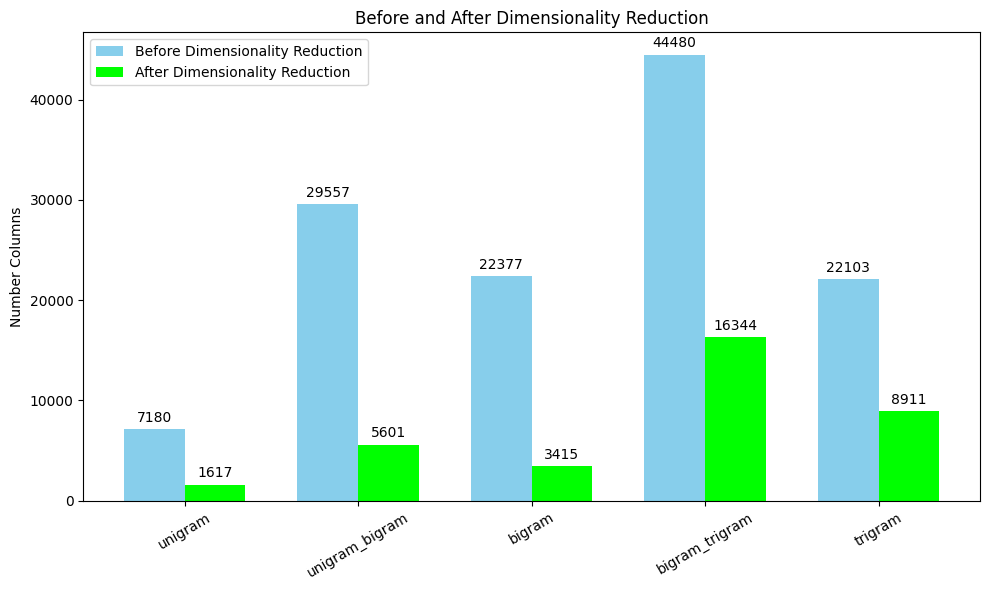

In [29]:
labels = n_gram_df_dim['N-Gram Feature Vector'].values
b4 = [shape[1] for shape in n_gram_df['Data Dimension'].values]
af = [shape[1] for shape in n_gram_df_dim['Data Dimension'].values]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, b4, width, label='Before Dimensionality Reduction', color='skyblue')
rects2 = ax.bar(x + width/2, af, width, label='After Dimensionality Reduction', color='lime')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number Columns')
ax.set_title('Before and After Dimensionality Reduction')
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [30]:
param_grid = {'n_neighbors': [5,7,9,11,13,15,17,19,21]}
base_estimator = KNeighborsClassifier()
knn_result = get_performance(param_grid, base_estimator, dataframes)
knn_result

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,KNeighborsClassifier(n_neighbors=9),0.238746,0.198736
1,unigram,precision_macro,KNeighborsClassifier(n_neighbors=9),0.460239,0.268799
2,unigram,recall_macro,KNeighborsClassifier(n_neighbors=21),0.298790,0.245368
3,unigram_bigram,f1_macro,KNeighborsClassifier(),0.214026,0.215972
4,unigram_bigram,precision_macro,KNeighborsClassifier(n_neighbors=7),0.359669,0.296433
5,unigram_bigram,recall_macro,KNeighborsClassifier(n_neighbors=7),0.260729,0.259429
6,bigram,f1_macro,KNeighborsClassifier(n_neighbors=19),0.118677,0.118484
7,bigram,precision_macro,KNeighborsClassifier(n_neighbors=19),0.192662,0.328045
8,bigram,recall_macro,KNeighborsClassifier(n_neighbors=19),0.256282,0.205956
9,bigram_trigram,f1_macro,KNeighborsClassifier(n_neighbors=15),0.120196,0.114509


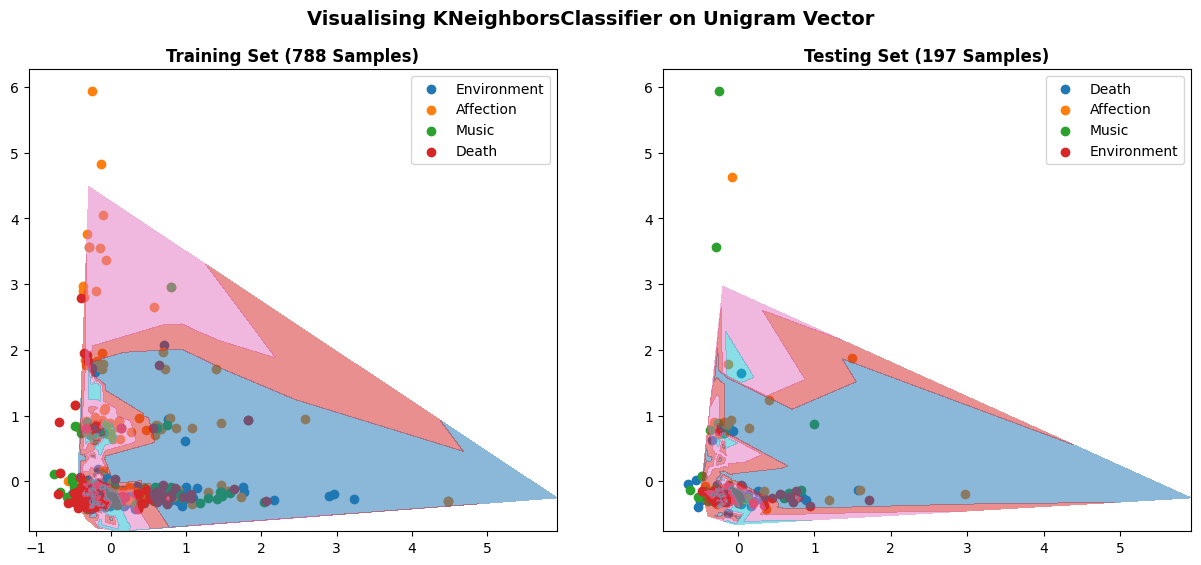

In [31]:
best_vector, best_clf =  get_best_vector_clf(knn_result)
vis_classification(vector_type = best_vector, estimator = best_clf)

In [32]:
param_grid = {'max_depth': [None,4,6,7,8,30,32,35],'min_samples_split': [2,3,4,5,35,10,16,20]}
base_estimator = DecisionTreeClassifier(random_state=random_state_number)
dtc_result = get_performance(param_grid, base_estimator, dataframes)
dtc_result

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
0,unigram,f1_macro,"DecisionTreeClassifier(min_samples_split=16, random_state=1234)",0.402508,0.307305
1,unigram,precision_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=1234)",0.482312,0.415570
2,unigram,recall_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=1234)",0.382327,0.347412
3,unigram_bigram,f1_macro,DecisionTreeClassifier(random_state=1234),0.398631,0.380372
4,unigram_bigram,precision_macro,"DecisionTreeClassifier(max_depth=8, random_state=1234)",0.472177,0.411551
5,unigram_bigram,recall_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=3, random_state=1234)",0.379728,0.358127
6,bigram,f1_macro,"DecisionTreeClassifier(min_samples_split=10, random_state=1234)",0.152903,0.151540
7,bigram,precision_macro,"DecisionTreeClassifier(min_samples_split=10, random_state=1234)",0.311666,0.202966
8,bigram,recall_macro,"DecisionTreeClassifier(min_samples_split=35, random_state=1234)",0.262151,0.254954
9,bigram_trigram,f1_macro,"DecisionTreeClassifier(min_samples_split=3, random_state=1234)",0.133962,0.140947


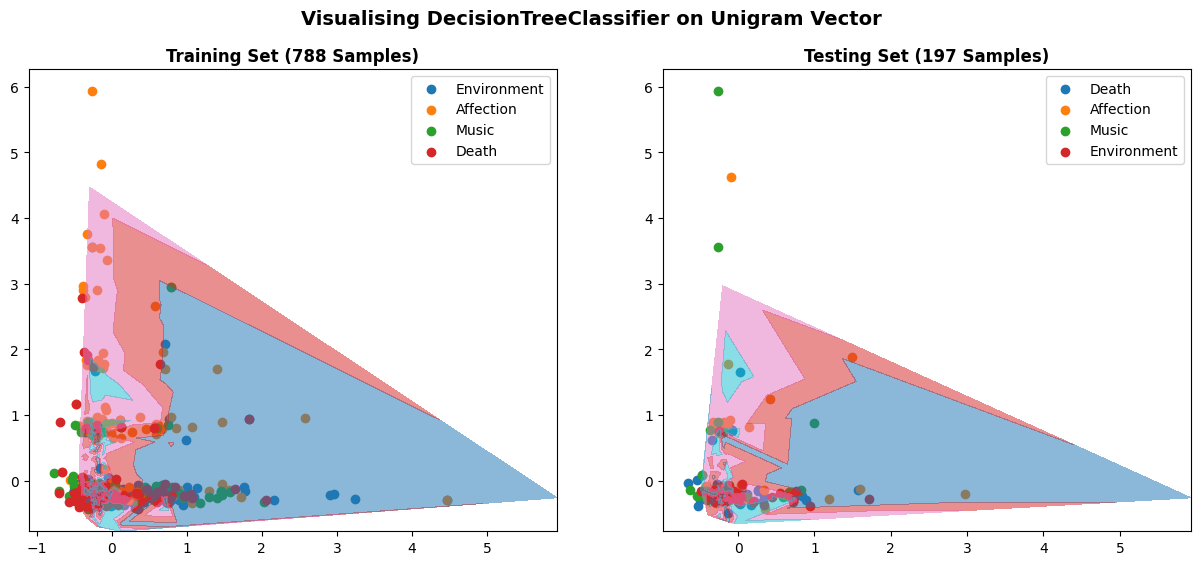

In [33]:
best_vector, best_clf =  get_best_vector_clf(dtc_result)
vis_classification(vector_type = best_vector, estimator = best_clf)

In [34]:
df_result = pd.concat([knn_result, 
                      dtc_result,
                      rfc_result
                      ]
                     ).reset_index(drop=True)

agg_funcs = {
    'Best CV Metric Score': 'max', 
    'Test Predict Metric Score': 'max', 
    'Calibrated Estimator': 'first',
    'Vector': 'first'
}

df_result_max = df_result.groupby(['Metric']).agg(agg_funcs)
df_result_max

,Best CV Metric Score,Test Predict Metric Score,Calibrated Estimator,Vector
Metric,,,,
f1_macro,0.440763,0.463258,KNeighborsClassifier(n_neighbors=9),unigram
precision_macro,0.482312,0.457169,KNeighborsClassifier(n_neighbors=9),unigram
recall_macro,0.453674,0.465550,KNeighborsClassifier(n_neighbors=21),unigram


## Obtain Best Classifier and Feature Vector

In [35]:
def get_best_result(df_result, metric_score):
    df_result_t = df_result[df_result.Metric== 'precision_macro']
    precision_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    df_result_t = df_result[df_result.Metric== 'recall_macro']
    recall_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T
    
    df_result_t = df_result[df_result.Metric== 'f1_macro']
    f1_macro_df = df_result_t.loc[df_result_t[metric_score].idxmax()].to_frame().T

    return pd.concat([precision_macro_df,recall_macro_df,f1_macro_df])

In [36]:
best_cv_result = get_best_result(df_result, 'Best CV Metric Score')
display(best_cv_result)
temp = best_cv_result[best_cv_result['Metric'] == 'f1_macro']
best_clf = temp['Calibrated Estimator'].values[0]
best_vector = temp['Vector'].values[0]

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
16,unigram,precision_macro,"DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=1234)",0.482312,0.41557
32,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=30, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=30...",0.453674,0.46555
30,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=40, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=40, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=40...",0.440763,0.463258


In [37]:
get_best_result(df_result, 'Test Predict Metric Score')

,Vector,Metric,Calibrated Estimator,Best CV Metric Score,Test Predict Metric Score
34,unigram_bigram,precision_macro,"(DecisionTreeClassifier(max_depth=35, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=35, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=35...",0.440094,0.457169
32,unigram,recall_macro,"(DecisionTreeClassifier(max_depth=30, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=30, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=30...",0.453674,0.46555
30,unigram,f1_macro,"(DecisionTreeClassifier(max_depth=40, max_features='sqrt',\n random_state=822569775), DecisionTreeClassifier(max_depth=40, max_features='sqrt',\n random_state=2137449171), DecisionTreeClassifier(max_depth=40...",0.440763,0.463258


## Evaluate on Each Class Labels

In [38]:
X_train, X_test, y_train, y_test = train_test_split(dataframes[best_vector], df_target, test_size=0.2, \
                                                    random_state=random_state_number)
clf = best_clf.fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
target_names = df1['genre'].unique()
print(classification_report(y_test,y_test_pred,target_names=target_names))

              precision    recall  f1-score   support

       Music       0.49      0.53      0.51        40
       Death       0.55      0.32      0.40        56
   Affection       0.51      0.51      0.51        51
 Environment       0.36      0.50      0.42        50

    accuracy                           0.46       197
   macro avg       0.48      0.46      0.46       197
weighted avg       0.48      0.46      0.46       197



In [39]:
sample_predict = pd.DataFrame({'Actual Y Test': le.inverse_transform(y_test),'Best Prediction':le.inverse_transform(y_test_pred)})
sample_predict.head(20)

,Actual Y Test,Best Prediction
0,Death,Death
1,Affection,Affection
2,Music,Environment
3,Music,Affection
4,Environment,Environment
5,Environment,Environment
6,Affection,Death
7,Death,Music
8,Music,Environment
9,Environment,Music
